In [48]:
import av
import numpy as np
from numpy.random import randint
from time import sleep
from einops.layers.torch import Rearrange
from typing import List, Tuple
import torch
from torchvision.transforms import Compose

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
os.chdir('../')

from src.opts.opts import parser
from src.utils.reproducibility import make_reproducible
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset
from src.dataset.video_dataset import prepare_clips_data
from src.dataset.video_transforms import GroupMultiScaleCrop, Stack, ToTorchFormatTensor, GroupRandomHorizontalFlip

In [3]:
args = parser.parse_args(args=[])
args.base_model = 'InceptionV3'
args.fusion_mode = "GSF"
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1',
 'fine_grained_actions_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'base_model': 'InceptionV3',
 'fusion_mode': 'GSF',
 'num_segments': 8,
 'num_classes': 1887,
 'resume': None,
 'start_epoch': 0,
 'num_epochs': 10,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'batch_size': 16,
 'num_workers': 4,
 'prefetch_factor': 2,
 'debug': False}

# Path to videos

In [30]:
tr_clip_path_to_video_arr, tr_clip_start_arr, tr_clip_end_arr, tr_clip_action_id_arr, tr_clip_mistake_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fine_grained_actions_map_file=args.fine_grained_actions_map_file,
    mode="train",
)

There are 7 videos in the list There are 13 videos as video files There are 0 videos that present in the list but are missing as videos.
Number of clips: 507 for mode train


In [31]:
tr_clip_path_to_video_arr[123], tr_clip_start_arr[123], tr_clip_end_arr[123], tr_clip_action_id_arr[123], tr_clip_mistake_arr[123]

(b'/Users/artemmerinov/data/holoassist/video_pitch_shifted/R0027-12-GoPro/Export_py/Video_pitchshift.mp4',
 378.588,
 380.211,
 38,
 0)

# Check functions

In [91]:
from src.dataset.frame_loader import load_av_frames_from_video
from src.dataset.temporal_sampling import temporal_sampling

In [92]:
# Extract frames from video using start and end time. 
frames = load_av_frames_from_video(
    path_to_video="/Users/artemmerinov/data/holoassist/video_pitch_shifted/R0027-12-GoPro/Export_py/Video_pitchshift.mp4",
    start_secs=378.588, 
    end_secs=380.211,
)

In [93]:
frames

[<av.VideoFrame #78, pts=281469573 yuv420p 896x504 at 0x7f7d3e34d000>,
 <av.VideoFrame #79, pts=281499966 yuv420p 896x504 at 0x7f7d3e34cba0>,
 <av.VideoFrame #80, pts=281530359 yuv420p 896x504 at 0x7f7d3e34d070>,
 <av.VideoFrame #81, pts=281560752 yuv420p 896x504 at 0x7f7d3e34d0e0>,
 <av.VideoFrame #82, pts=281591145 yuv420p 896x504 at 0x7f7d3e34d150>,
 <av.VideoFrame #83, pts=281621538 yuv420p 896x504 at 0x7f7d3e34d1c0>,
 <av.VideoFrame #84, pts=281651931 yuv420p 896x504 at 0x7f7d3e34d230>,
 <av.VideoFrame #85, pts=281682324 yuv420p 896x504 at 0x7f7d3e34d2a0>,
 <av.VideoFrame #86, pts=281712717 yuv420p 896x504 at 0x7f7d3e34d310>,
 <av.VideoFrame #87, pts=281743110 yuv420p 896x504 at 0x7f7d3e34d380>,
 <av.VideoFrame #88, pts=281773503 yuv420p 896x504 at 0x7f7d3e34d3f0>,
 <av.VideoFrame #89, pts=281803896 yuv420p 896x504 at 0x7f7d3e34d460>,
 <av.VideoFrame #90, pts=281834289 yuv420p 896x504 at 0x7f7d3e34d4d0>,
 <av.VideoFrame #91, pts=281864682 yuv420p 896x504 at 0x7f7d3e34d540>,
 <av.V

In [94]:
def temporal_sampling(
        frames: List[av.video.frame.VideoFrame],
        num_segments: int,
        mode: str = "train",
    ) -> Tuple[np.ndarray, List[av.video.frame.VideoFrame]]:
    """
    Given the list of frames, sample `num_samples` frames.
    """
    num_frames = len(frames)
    average_duration = num_frames // num_segments

    if mode != "test":
        if average_duration > 0:
            segment_indices = (
                np.multiply(list(range(num_segments)), average_duration) + 
                randint(average_duration, size=num_segments)
            )
        else:
            segment_indices = np.zeros((num_segments,), dtype="int64")
    else:
        raise NotImplementedError()
    
    frames =  [frames[i] for i in segment_indices]

    # Since other modalities might have different frequencies,
    # we will also output the time portions of sampled frames.
    # So, we can easily select syncronised data from other modalities 
    # based on this sampling.
    sampling_portions = segment_indices / num_frames
    
    return sampling_portions, frames

In [95]:
# Perform temporal sampling
sampling_portions, frames = temporal_sampling(
    frames=frames,
    num_segments=8,
    mode="train"
)

In [96]:
frames

[<av.VideoFrame #78, pts=281469573 yuv420p 896x504 at 0x7f7d3e34d000>,
 <av.VideoFrame #84, pts=281651931 yuv420p 896x504 at 0x7f7d3e34d230>,
 <av.VideoFrame #89, pts=281803896 yuv420p 896x504 at 0x7f7d3e34d460>,
 <av.VideoFrame #94, pts=281955861 yuv420p 896x504 at 0x7f7d3e34d690>,
 <av.VideoFrame #99, pts=282107826 yuv420p 896x504 at 0x7f7d3e34d8c0>,
 <av.VideoFrame #106, pts=282320577 yuv420p 896x504 at 0x7f7d3e34dbd0>,
 <av.VideoFrame #111, pts=282472542 yuv420p 896x504 at 0x7f7d3e34de00>,
 <av.VideoFrame #115, pts=282594114 yuv420p 896x504 at 0x7f7d3e34dfc0>]

In [97]:
sampling_portions

array([0.        , 0.14634146, 0.26829268, 0.3902439 , 0.51219512,
       0.68292683, 0.80487805, 0.90243902])

# Check entire dataloader with/without transformations

In [13]:
# Fix random state to make results reproducible
make_reproducible(random_seed=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoModel(
    num_classes=args.num_classes, 
    num_segments=args.num_segments, 
    base_model=args.base_model,
    fusion_mode=args.fusion_mode,
    verbose=False,
).to(device)

input_size = model.input_size
crop_size = model.crop_size
input_mean = model.input_mean
input_std = model.input_std
div = model.div

Making reproducible on seed 0
=> Using GSF fusion
No. of GSF modules = 11


# Without transform

In [8]:
tr_dataset = VideoDataset(
    clip_path_to_video_arr=tr_clip_path_to_video_arr,
    clip_start_arr=tr_clip_start_arr,
    clip_end_arr=tr_clip_end_arr,
    clip_label_arr=tr_clip_action_id_arr,
    num_segments=args.num_segments,
    transform=None,
    mode="train",
)

In [9]:
len(tr_dataset)

507

In [10]:
tr_dataset[338]

([<PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>],
 1327)

In [11]:
frames, action = tr_dataset[338]

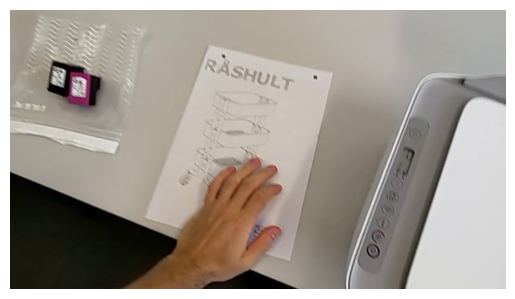

In [12]:
plt.figure()
for i in range(len(frames)):
    plt.imshow(frames[i])
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)

# With transform

In [22]:
tr_transform = Compose([
    GroupMultiScaleCrop(crop_size, [1, .875]),
    GroupRandomHorizontalFlip(),
    Stack(roll=False),
    ToTorchFormatTensor(div=div),
    # GroupNormalize(mean=input_mean, std=input_std), # this is for model and not for visualisation
])

tr_dataset = VideoDataset(
    clip_path_to_video_arr=tr_clip_path_to_video_arr,
    clip_start_arr=tr_clip_start_arr,
    clip_end_arr=tr_clip_end_arr,
    clip_label_arr=tr_clip_action_id_arr,
    num_segments=args.num_segments,
    transform=tr_transform,
    mode="train"
)

In [23]:
np_frames, action = tr_dataset[2]
print(action)

np_frames = Rearrange("(t c) h w -> t c h w", c=3, t=args.num_segments, h=input_size, w=input_size)(np_frames)
print(np_frames.shape)

2
torch.Size([8, 3, 299, 299])


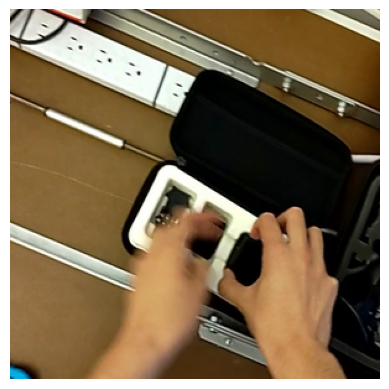

In [24]:
plt.figure()
for i in range(len(np_frames)):
    plt.imshow(np_frames[i].permute(1, 2, 0).cpu().numpy());
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)